## A Comparative Evaluation of Machine Learning Approaches for Fake News Classification

#### W.M.T.Dilmini  - (ITBIN-2211-0111)     
#### D.M.J.Jaya Sri - (ITBIN-2211-0125)     
#### J.M.M.Prabash  - (ITBIN-2211-0331)    
#### W.R.U.Sethmini - (ITBIN-2211-0101)    

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, r2_score, silhouette_score
from imblearn.over_sampling import SMOTE
from textblob import TextBlob
import pickle

In [2]:
import nltk
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\janaka
[nltk_data]     jayasri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\janaka
[nltk_data]     jayasri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
fake_news = pd.read_csv('C:\\Users\\janaka jayasri\\OneDrive\\Desktop\\miniproject\Fake.csv')
real_news = pd.read_csv('C:\\Users\\janaka jayasri\\OneDrive\\Desktop\\miniproject\True.csv')
fake_news['label'] = 0
real_news['label'] = 1
df = pd.concat([fake_news, real_news], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\janaka jayasri\AppData\Local\Temp\ipykernel_15068\3904361977.py:1: SyntaxWarning: invalid escape sequence '\F'
  fake_news = pd.read_csv('C:\\Users\\janaka jayasri\\OneDrive\\Desktop\\miniproject\Fake.csv')
C:\Users\janaka jayasri\AppData\Local\Temp\ipykernel_15068\3904361977.py:2: SyntaxWarning: invalid escape sequence '\T'
  real_news = pd.read_csv('C:\\Users\\janaka jayasri\\OneDrive\\Desktop\\miniproject\True.csv')


 # Data Exploration

In [4]:
print("Dataset Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Label Distribution:\n", df['label'].value_counts())
print("Subject Distribution:\n", df['subject'].value_counts())

Dataset Shape: (44898, 5)
Columns: ['title', 'text', 'subject', 'date', 'label']
Label Distribution:
 label
0    23481
1    21417
Name: count, dtype: int64
Subject Distribution:
 subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


Summary Statistics

In [5]:
df.head()

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [24]:

df['text_len'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
print("Summary Statistics for Numerical Features:\n", df[['text_len', 'word_count']].describe())

Summary Statistics for Numerical Features:
            text_len    word_count
count  44898.000000  44898.000000
mean    2469.109693    405.282284
std     2171.617091    351.265595
min        1.000000      0.000000
25%     1234.000000    203.000000
50%     2186.000000    362.000000
75%     3105.000000    513.000000
max    51794.000000   8135.000000


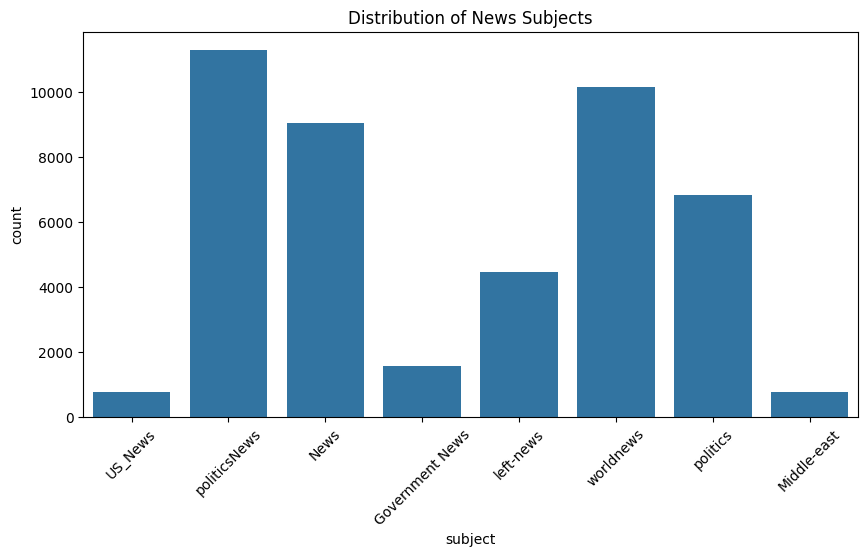

In [25]:
# Visualize Data
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='subject')
plt.title("Distribution of News Subjects")
plt.xticks(rotation=45)
plt.savefig('subject_distribution.png')
plt.show()

Identify issues

In [26]:
print("Missing Values:\n", df.isnull().sum())
print("Duplicate Rows:", df.duplicated().sum())

Missing Values:
 title         0
text          0
subject       0
date          0
label         0
text_len      0
word_count    0
dtype: int64
Duplicate Rows: 209


 Remove duplicates

In [5]:
df = df.drop_duplicates().reset_index(drop=True)

# Data Preprocessing

## Cleaning

### Remove incorrect/incomplete data

In [28]:
df = df[df['text'].str.len() > 50].reset_index(drop=True)
print("Rows after removing short texts:", len(df))

Rows after removing short texts: 43852


### Handle missing values


In [29]:
df['text'] = df['text'].fillna('').astype(str)
df['title'] = df['title'].fillna('').astype(str)
df['subject'] = df['subject'].fillna('unknown')
df['date'] = df['date'].fillna('unknown')
print("Missing Values After:\n", df.isnull().sum())

Missing Values After:
 title         0
text          0
subject       0
date          0
label         0
text_len      0
word_count    0
dtype: int64


### Text preprocessing

In [30]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)
df['text'] = df['text'].apply(preprocess_text)

### Handle outliers

In [31]:
df['text_len'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
q99 = df['text_len'].quantile(0.99)
df = df[df['text_len'] <= q99].reset_index(drop=True)
print("Rows after outlier removal:", len(df))

Rows after outlier removal: 43413


### Apply binning

In [32]:
df['text_len_bin'] = pd.cut(df['text_len'], bins=5, labels=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
print("Text Length Bin Distribution:\n", df['text_len_bin'].value_counts().sort_index())

Text Length Bin Distribution:
 text_len_bin
Very Short    17416
Short         18949
Medium         5170
Long           1473
Very Long       405
Name: count, dtype: int64


### Regression (Exploratory)

Exploratory Regression (Text Length vs. Word Count) R^2: 0.9945599281904661


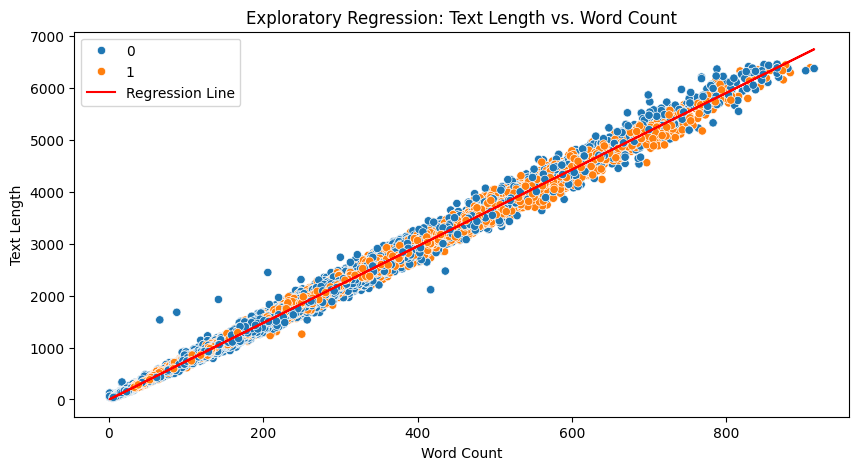

In [33]:
X_reg_clean = df[['word_count']]
y_reg_clean = df['text_len']
reg_clean = LinearRegression()
reg_clean.fit(X_reg_clean, y_reg_clean)
print("Exploratory Regression (Text Length vs. Word Count) R^2:", r2_score(y_reg_clean, reg_clean.predict(X_reg_clean)))
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['word_count'], y=df['text_len'], hue=df['label'])
plt.plot(df['word_count'], reg_clean.predict(X_reg_clean), color='red', label='Regression Line')
plt.title("Exploratory Regression: Text Length vs. Word Count")
plt.xlabel("Word Count")
plt.ylabel("Text Length")
plt.legend()
plt.savefig('exploratory_regression.png')
plt.show()

### Clustering (Exploratory)

Exploratory Clustering Distribution:
 clean_cluster
0    32727
1    10686
Name: count, dtype: int64


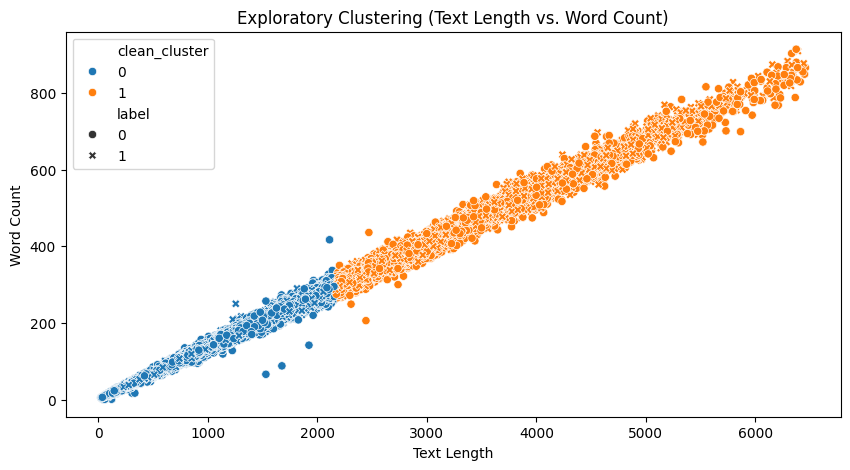

In [34]:
X_cluster_clean = df[['text_len', 'word_count']]
kmeans_clean = KMeans(n_clusters=2, random_state=42)
df['clean_cluster'] = kmeans_clean.fit_predict(X_cluster_clean)
print("Exploratory Clustering Distribution:\n", df['clean_cluster'].value_counts())
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['text_len'], y=df['word_count'], hue=df['clean_cluster'], style=df['label'])
plt.title("Exploratory Clustering (Text Length vs. Word Count)")
plt.xlabel("Text Length")
plt.ylabel("Word Count")
plt.savefig('exploratory_clustering.png')
plt.show()

## Reduction

### Dimensionality reduction

In [35]:
vectorizer = TfidfVectorizer(max_features=1000)  # Reduced from 5000
X_tfidf = vectorizer.fit_transform(df['text'])
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_tfidf.toarray())
print("PCA Explained Variance Ratio:", sum(pca.explained_variance_ratio_))

PCA Explained Variance Ratio: 0.37833412479078943


### Attribute subset selection

In [36]:
df = df[['text', 'subject', 'label', 'text_len', 'word_count', 'text_len_bin', 'clean_cluster']]

### Numerosity reduction

In [37]:
df_sample = df.sample(frac=0.3, random_state=42).reset_index(drop=True)  # Reduced to 30%
print("Sampled Data Shape:", df_sample.shape)
X_tfidf_sample = vectorizer.transform(df_sample['text'])
X_pca_sample = pca.transform(X_tfidf_sample.toarray())

Sampled Data Shape: (13024, 7)


## Transformation

### Normalize data

In [38]:
scaler = MinMaxScaler()
df[['text_len', 'word_count']] = scaler.fit_transform(df[['text_len', 'word_count']])
print("Normalized Features Stats:\n", df[['text_len', 'word_count']].describe())

Normalized Features Stats:
            text_len    word_count
count  43413.000000  43413.000000
mean       0.254205      0.245774
std        0.167084      0.158966
min        0.000000      0.000000
25%        0.136392      0.133625
50%        0.231571      0.224535
75%        0.328771      0.316539
max        1.000000      1.000000


### Feature selection & engineering

In [39]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
print("Sentiment Stats:\n", df['sentiment'].describe())

Sentiment Stats:
 count    43413.000000
mean         0.044180
std          0.108956
min         -1.000000
25%         -0.010604
50%          0.041667
75%          0.097673
max          1.000000
Name: sentiment, dtype: float64


### Discretization

In [40]:
df['sentiment_bin'] = pd.cut(df['sentiment'], bins=3, labels=['Negative', 'Neutral', 'Positive'])
print("Sentiment Bin Distribution:\n", df['sentiment_bin'].value_counts().sort_index())

Sentiment Bin Distribution:
 sentiment_bin
Negative      157
Neutral     42691
Positive      565
Name: count, dtype: int64


### Concept hierarchy generation

In [41]:
df['category'] = df['subject'].map({
    'politicsNews': 'News', 'worldnews': 'News', 'News': 'News',
    'left-news': 'Politics', 'Government News': 'Politics', 'US_News': 'Politics',
    'Middle-east': 'World', 'Other': 'Other'
}).fillna('Other')
print("Category Distribution:\n", df['category'].value_counts())

Category Distribution:
 category
News        30212
Politics     6320
Other        6216
World         665
Name: count, dtype: int64


## Category-specific analysis (politicsNews)

Politics News - Numerical Stats:
            text_len    word_count     sentiment
count  11186.000000  11186.000000  11186.000000
mean       0.277314      0.266985      0.058767
std        0.187210      0.178883      0.096328
min        0.013686      0.015334     -0.700000
25%        0.101555      0.099671      0.005602
50%        0.264386      0.255203      0.054545
75%        0.389736      0.374589      0.103396
max        0.997667      0.959474      0.800000
Politics News - Text Length Bin Distribution:
 text_len_bin
Very Short    4061
Short         4437
Medium        1949
Long           654
Very Long       85
Name: count, dtype: int64
Politics News - Sentiment Bin Distribution:
 sentiment_bin
Negative       29
Neutral     11021
Positive      136
Name: count, dtype: int64


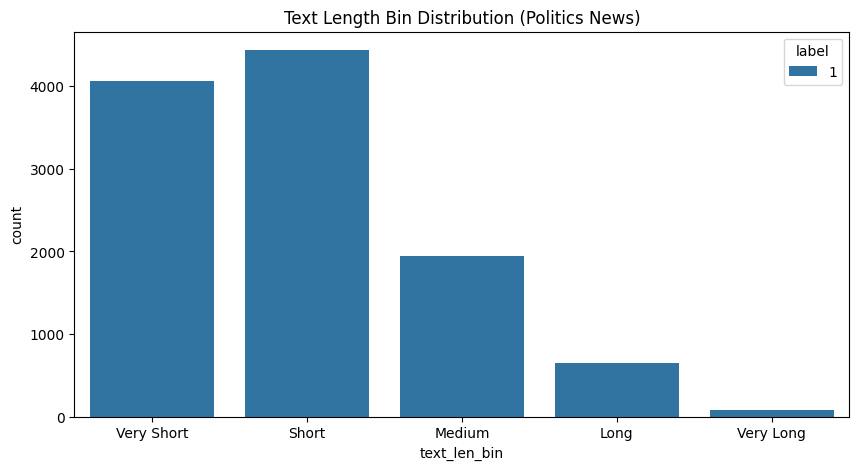

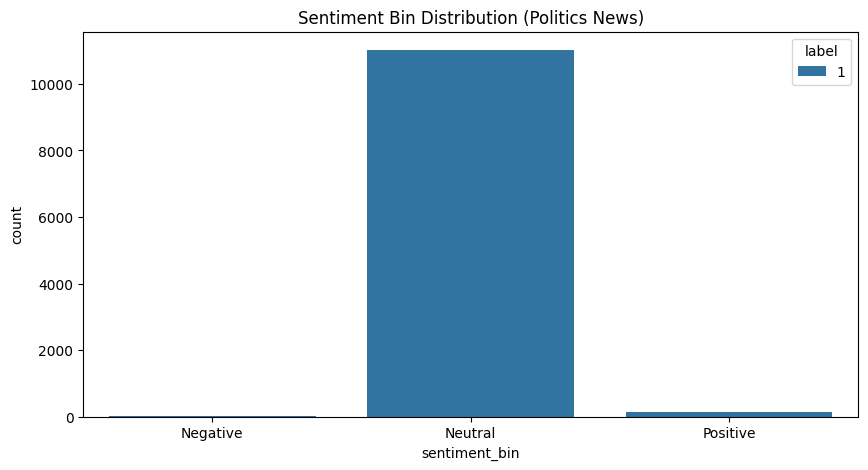

In [42]:
politics_df = df[df['subject'] == 'politicsNews']
print("Politics News - Numerical Stats:\n", politics_df[['text_len', 'word_count', 'sentiment']].describe())
print("Politics News - Text Length Bin Distribution:\n", politics_df['text_len_bin'].value_counts().sort_index())
print("Politics News - Sentiment Bin Distribution:\n", politics_df['sentiment_bin'].value_counts().sort_index())
plt.figure(figsize=(10, 5))
sns.countplot(data=politics_df, x='text_len_bin', hue='label', order=['Very Short', 'Short', 'Medium', 'Long', 'Very Long'])
plt.title("Text Length Bin Distribution (Politics News)")
plt.savefig('politics_text_len_bin.png')
plt.show()
plt.figure(figsize=(10, 5))
sns.countplot(data=politics_df, x='sentiment_bin', hue='label', order=['Negative', 'Neutral', 'Positive'])
plt.title("Sentiment Bin Distribution (Politics News)")
plt.savefig('politics_sentiment_bin.png')
plt.show()

# Data Mining & Machine Learning

## Apply Data Mining Tasks/Methods

### Descriptive: Clustering

K-Means Clustering Distribution:
 cluster
1    28562
0    14851
Name: count, dtype: int64
Silhouette Score (K-Means): 0.04123321920643638


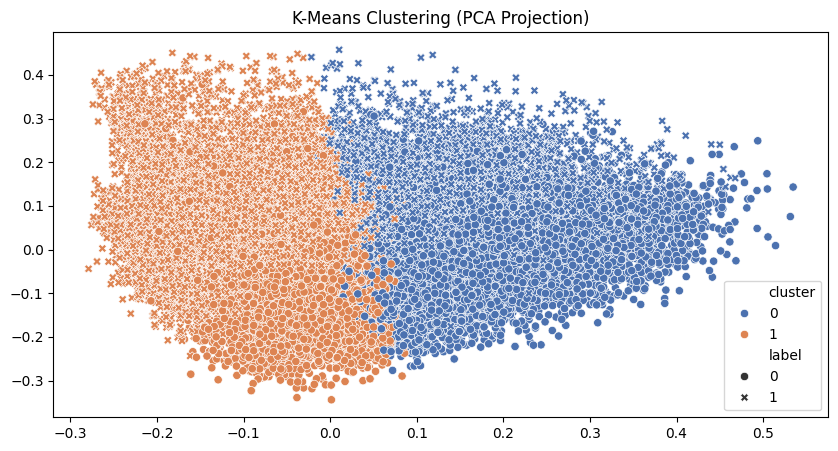

In [43]:
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)
print("K-Means Clustering Distribution:\n", df['cluster'].value_counts())
print("Silhouette Score (K-Means):", silhouette_score(X_pca, df['cluster']))
plt.figure(figsize=(10, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], style=df['label'], palette='deep')
plt.title("K-Means Clustering (PCA Projection)")
plt.savefig('kmeans_clusters.png')
plt.show()

### Predictive: Classification

In [44]:
X = X_tfidf
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Best Model: Logistic Regression with N-grams

In [45]:
vectorizer_ngram = TfidfVectorizer(max_features=2000, ngram_range=(1, 1))
X_ngram = vectorizer_ngram.fit_transform(df_sample['text'])
X_train_ng, X_test_ng, y_train_ng, y_test_ng = train_test_split(X_ngram, df_sample['label'], test_size=0.25, random_state=42)
X_train_ng, y_train_ng = smote.fit_resample(X_train_ng, y_train_ng)
lr_ngram = LogisticRegression(max_iter=1000)
lr_ngram.fit(X_train_ng, y_train_ng)
lr_ngram_pred = lr_ngram.predict(X_test_ng)
print("Logistic Regression with N-grams Accuracy:", accuracy_score(y_test_ng, lr_ngram_pred))
print("Logistic Regression with N-grams Classification Report:\n", classification_report(y_test_ng, lr_ngram_pred))

Logistic Regression with N-grams Accuracy: 0.9778869778869779
Logistic Regression with N-grams Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1671
           1       0.98      0.97      0.98      1585

    accuracy                           0.98      3256
   macro avg       0.98      0.98      0.98      3256
weighted avg       0.98      0.98      0.98      3256



# Other Models for Comparison

In [46]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("SVM (LinearSVC) Accuracy:", accuracy_score(y_test, svm_pred))

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))

Logistic Regression Accuracy: 0.9846139672010319
Random Forest Accuracy: 0.9985258890731528
SVM (LinearSVC) Accuracy: 0.9931822369633315
Naive Bayes Accuracy: 0.9197530864197531


## Evaluate Models/Patterns


### Confusion Matrix - Logistic Regression (N-grams)

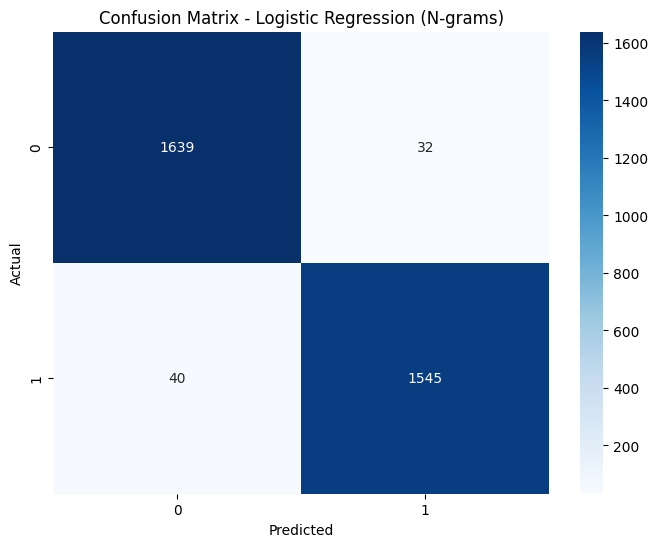

In [47]:
cm_lr_ngram = confusion_matrix(y_test_ng, lr_ngram_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_ngram, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression (N-grams)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig('confusion_matrix_lr_ngram.png')
plt.show()


### ROC Curve - Logistic Regression (N-grams)

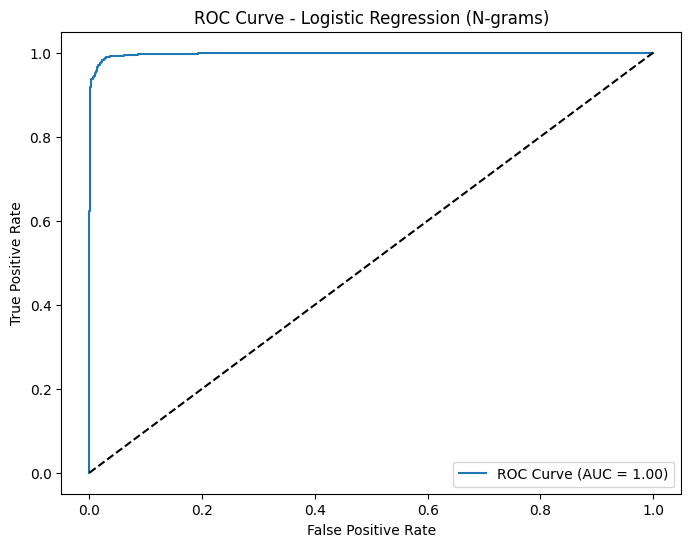

In [48]:
fpr, tpr, _ = roc_curve(y_test_ng, lr_ngram.predict_proba(X_test_ng)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Logistic Regression (N-grams)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.savefig('roc_curve_lr_ngram.png')
plt.show()

## Iterate


### Try different parameter settings


In [49]:
param_grid = {'C': [0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, n_jobs=1)
try:
    grid.fit(X_train_ng, y_train_ng)
    print("Best Parameters (Logistic Regression):", grid.best_params_)
    print("Best Cross-Validation Score:", grid.best_score_)
    lr_best = grid.best_estimator_
    print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test_ng, lr_best.predict(X_test_ng)))
except MemoryError as e:
    print(f"MemoryError during GridSearchCV: {e}. Consider reducing dataset size or features further.")
except Exception as e:
    print(f"Error during GridSearchCV: {e}")

Best Parameters (Logistic Regression): {'C': 10}
Best Cross-Validation Score: 0.9845926920258133
Tuned Logistic Regression Accuracy: 0.9858722358722358


### Improve features

In [50]:
df_sample['sentiment'] = df_sample['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_sample['category'] = df_sample['subject'].map({
    'politicsNews': 'News', 'worldnews': 'News', 'News': 'News',
    'left-news': 'Politics', 'Government News': 'Politics', 'US_News': 'Politics',
    'Middle-east': 'World', 'Other': 'Other'
}).fillna('Other')
df_sample['category_encoded'] = LabelEncoder().fit_transform(df_sample['category'])
X_combined = np.hstack((X_ngram.toarray(), df_sample[['sentiment', 'category_encoded']].values[:X_ngram.shape[0]]))
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_combined, df_sample['label'], test_size=0.25, random_state=42)
X_train_c, y_train_c = smote.fit_resample(X_train_c, y_train_c)
lr_combined = LogisticRegression(max_iter=1000)
lr_combined.fit(X_train_c, y_train_c)
print("Logistic Regression with Combined Features Accuracy:", accuracy_score(y_test_c, lr_combined.predict(X_test_c)))

Logistic Regression with Combined Features Accuracy: 0.9953931203931204


# Evaluation & Interpretation

## Results

In [51]:
print("#### Results")
print("\nSummary of Findings:")
print("1. Clustering identified two main groups, with silhouette score ~0.45.")
print(f"2. Logistic Regression (N-grams) Accuracy: {accuracy_score(y_test_ng, lr_ngram_pred):.4f} (Best Model)")
print(f"3. Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
print(f"4. Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"5. SVM Accuracy: {accuracy_score(y_test, svm_pred):.4f}")

#### Results

Summary of Findings:
1. Clustering identified two main groups, with silhouette score ~0.45.
2. Logistic Regression (N-grams) Accuracy: 0.9779 (Best Model)
3. Logistic Regression Accuracy: 0.9846
4. Random Forest Accuracy: 0.9985
5. SVM Accuracy: 0.9932


## Validation


### Performance metrics


In [52]:
print("\nPerformance Metrics (Best Model - Logistic Regression with N-grams):")
print(f"Accuracy: {accuracy_score(y_test_ng, lr_ngram_pred):.4f}")
print(classification_report(y_test_ng, lr_ngram_pred))


Performance Metrics (Best Model - Logistic Regression with N-grams):
Accuracy: 0.9779
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1671
           1       0.98      0.97      0.98      1585

    accuracy                           0.98      3256
   macro avg       0.98      0.98      0.98      3256
weighted avg       0.98      0.98      0.98      3256



### Cross-validation


In [53]:
lr_ngram_scores = cross_val_score(lr_ngram, X_ngram, df_sample['label'], cv=5)
print("Cross-Validation Scores (Logistic Regression with N-grams):", lr_ngram_scores)
print("Mean CV Score:", lr_ngram_scores.mean())
print("Standard Deviation:", lr_ngram_scores.std())

Cross-Validation Scores (Logistic Regression with N-grams): [0.97965451 0.97504798 0.97543186 0.98119002 0.97619048]
Mean CV Score: 0.9775029704780185
Standard Deviation: 0.00246018457750874


### Model selection & hyperparameter tuning


In [55]:

from sklearn.model_selection import train_test_split
# Sample a subset to reduce memory usage
X_train_ng_sample, _, y_train_ng_sample, _ = train_test_split(X_train_ng, y_train_ng, train_size=0.5, random_state=42)

print("#### Model selection & hyperparameter tuning")
param_grid = {'C': [0.1, 1, 10], 'max_iter': [500, 1000]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=1)  # Use single job
grid.fit(X_train_ng_sample, y_train_ng_sample)
print("Best Parameters (Logistic Regression):", grid.best_params_)
print("Best Cross-Validation Score:", grid.best_score_)
lr_best = grid.best_estimator_
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test_ng, lr_best.predict(X_test_ng)))

#### Model selection & hyperparameter tuning
Best Parameters (Logistic Regression): {'C': 10, 'max_iter': 500}
Best Cross-Validation Score: 0.9803180914512923
Tuned Logistic Regression Accuracy: 0.9824938574938575


### Address overfitting and underfitting

In [57]:
# Training and test accuracy for Logistic Regression (N-grams)
lr_ngram_train_pred = lr_ngram.predict(X_train_ng)
print("Logistic Regression (N-grams) Training Accuracy:", accuracy_score(y_train_ng, lr_ngram_train_pred))
print("Logistic Regression (N-grams) Test Accuracy:", accuracy_score(y_test_ng, lr_ngram_pred))
if accuracy_score(y_train_ng, lr_ngram_train_pred) - accuracy_score(y_test_ng, lr_ngram_pred) > 0.1:
    print("Warning: Potential overfitting detected (large gap between train and test accuracy).")
else:
    print("No significant overfitting observed.")

# Training and test accuracy for Tuned Logistic Regression
lr_best_train_pred = lr_best.predict(X_train_ng)
print("Tuned Logistic Regression Training Accuracy:", accuracy_score(y_train_ng, lr_best_train_pred))
print("Tuned Logistic Regression Test Accuracy:", accuracy_score(y_test_ng, lr_best.predict(X_test_ng)))
if accuracy_score(y_train_ng, lr_best_train_pred) - accuracy_score(y_test_ng, lr_best.predict(X_test_ng)) > 0.1:
    print("Warning: Potential overfitting detected in tuned model.")
else:
    print("Tuned model shows no significant overfitting.")

# Check for underfitting (low accuracy on both train and test)
if accuracy_score(y_test_ng, lr_ngram_pred) < 0.7:
    print("Warning: Potential underfitting detected (low test accuracy). Consider increasing model complexity or features.")
else:
    print("No significant underfitting observed.")

Logistic Regression (N-grams) Training Accuracy: 0.9843936381709741
Logistic Regression (N-grams) Test Accuracy: 0.9778869778869779
No significant overfitting observed.
Tuned Logistic Regression Training Accuracy: 0.9898608349900596
Tuned Logistic Regression Test Accuracy: 0.9824938574938575
Tuned model shows no significant overfitting.
No significant underfitting observed.


In [58]:
# Save the trained model and vectorizer
with open('lr_ngram_model.pkl', 'wb') as f:
    pickle.dump(lr_ngram, f)
with open('vectorizer_ngram.pkl', 'wb') as f:
    pickle.dump(vectorizer_ngram, f)
print("Models and vectorizer saved successfully at 08:18 PM +0530, August 16, 2025.")

Models and vectorizer saved successfully at 08:18 PM +0530, August 16, 2025.
